In [ ]:
# first things first, import all the necessary functions and modules
import os
from PIL import Image
from pymatreader import read_mat

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization)
from tensorflow.keras.optimizers import SGD

# 1. Preprocess
First we need to preprocess data in SVHN dataset. For this example we're gonna crop out every street number from each image and then place them into separate folders. Additionally, we're gonna discard images that are less than 40px in width and less than 80px in height.

In [2]:
def process_images(mat, current_folder, output_folder):
    corr_size = 0
    min_height = 100000
    min_width = 100000
    total_imgs = len(mat['digitStruct']['name'])
    for i, name in enumerate(mat['digitStruct']['name']):
        if i % 1000 == 0:
            print(f"Processing image {name}, [{i}/{total_imgs}]")

        imagename = current_folder + os.path.sep + name
        img = Image.open(imagename)
        width, height = img.size
        
        if width >= 40 and height >= 80:
            corr_size += 1
            
            bbox = mat['digitStruct']['bbox'][i]
            num_of_boxes = len(bbox['height']) if isinstance(bbox['height'], list) else 1
            for j in range(num_of_boxes):
                
                label = int(bbox['label'][j]) if isinstance(bbox['label'], list) else int(bbox['label'])
                label = 0 if label == 10 else label # since 10 is actually 0 in SVHN, here we correct label

                # create output folder for each class
                crop_folder = os.path.join(output_folder, f"{label}")
                if not os.path.exists(crop_folder):
                    os.makedirs(crop_folder)
            
                left = int(bbox['left'][j]) if isinstance(bbox['left'], list) else int(bbox['left'])
                upper = int(bbox['top'][j]) if isinstance(bbox['top'], list) else int(bbox['top'])
                width = int(bbox['width'][j]) if isinstance(bbox['width'], list) else int(bbox['width'])
                height = int(bbox['height'][j]) if isinstance(bbox['height'], list) else int(bbox['height'])

                # crop image
                crop = img.crop((left, upper, left + width, upper + height))

                crop_name = crop_folder + os.path.sep + "image_" + str(i) + "_" + str(j) + ".png"
                crop.save(crop_name)
        else:
            min_width = width
            min_height = height


    print('Number of images after filtering:', corr_size)

    print(f"Min size: {min_width}, {min_height}")

In [3]:
train_file = 'data/train/digitStruct.mat'
test_file = 'data/test/digitStruct.mat'

train_mat = read_mat(train_file)

In [4]:
process_images(train_mat, 'data/train', 'processed_data/')

Processing image 1.png, [0/33402]
Processing image 1001.png, [1000/33402]
Processing image 2001.png, [2000/33402]
Processing image 3001.png, [3000/33402]
Processing image 4001.png, [4000/33402]
Processing image 5001.png, [5000/33402]
Processing image 6001.png, [6000/33402]
Processing image 7001.png, [7000/33402]
Processing image 8001.png, [8000/33402]
Processing image 9001.png, [9000/33402]
Processing image 10001.png, [10000/33402]
Processing image 11001.png, [11000/33402]
Processing image 12001.png, [12000/33402]
Processing image 13001.png, [13000/33402]
Processing image 14001.png, [14000/33402]
Processing image 15001.png, [15000/33402]
Processing image 16001.png, [16000/33402]
Processing image 17001.png, [17000/33402]
Processing image 18001.png, [18000/33402]
Processing image 19001.png, [19000/33402]
Processing image 20001.png, [20000/33402]
Processing image 21001.png, [21000/33402]
Processing image 22001.png, [22000/33402]
Processing image 23001.png, [23000/33402]
Processing image 2

In [5]:
test_mat = read_mat(test_file)

In [6]:
process_images(test_mat, 'data/test', 'processed_data/') # 2546

Processing image 1.png, [0/13068]
Processing image 1001.png, [1000/13068]
Processing image 2001.png, [2000/13068]
Processing image 3001.png, [3000/13068]
Processing image 4001.png, [4000/13068]
Processing image 5001.png, [5000/13068]
Processing image 6001.png, [6000/13068]
Processing image 7001.png, [7000/13068]
Processing image 8001.png, [8000/13068]
Processing image 9001.png, [9000/13068]
Processing image 10001.png, [10000/13068]
Processing image 11001.png, [11000/13068]
Processing image 12001.png, [12000/13068]
Processing image 13001.png, [13000/13068]
Number of images after filtering: 3652
Min size: 91, 40


In [7]:
# Load dataset for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'processed_data',
    image_size=(64, 64),
    batch_size=64,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    label_mode='categorical' # prepare labels for training
)

Found 22535 files belonging to 10 classes.
Using 18028 files for training.


In [8]:
# Load dataset for training
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'processed_data',
    image_size=(64, 64),
    batch_size=64,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical' # prepare labels for training
)

Found 22535 files belonging to 10 classes.
Using 4507 files for validation.


In [9]:
# Check class names
class_num = len(train_ds.class_names)
train_ds.class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Now we're gonna display one example of each class, to ensure that preprocessing was correct

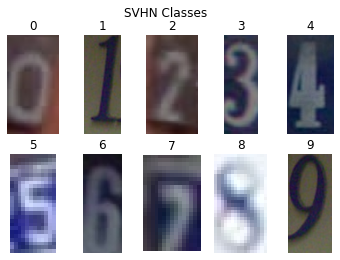

In [10]:
# Display one example for each class
fig = plt.figure()
fig.suptitle('SVHN Classes')
for i in train_ds.class_names:
    imgs = sorted(os.listdir(os.path.join('processed_data', i)))
    ax = plt.subplot(2, 5, int(i)+1)
    img = Image.open(os.path.join('processed_data', i, imgs[0]))
    plt.imshow(img)
    plt.title(i)
    plt.axis('off')

# 2. Train classifier

First we need to define a classifier. For this we're gonna use best architecture from SVHN paper with 8 convolutional layers. Every convolutional layer has max pooling and dropout. Kernel size for every convolutional layer is 5x5 and we use zero padding to preserve the representation size. Max pooling has window of size 2x2, while dropout rate is 0.2. Number of filters for first four layers are 48, 64, 128 and 160, followed by 192 filters in the remaining convolutional layers. Strides alternate between 2 and 1 for each layer, so taht half of the layers don't reduce the spatial size of the representation.

In [11]:
# One layer according to SVHN paper
def conv_layer(model, filters, strides, kernel_size):
    """Conv layer according to paper 'Multi-digit Number Recognition
        from Street View Imagery using Deep Convolutional Neural Networks'
    """

    model.add(Conv2D(filters, (kernel_size, kernel_size), padding='same'))

    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(strides, strides)))

    model.add(Dropout(0.2))

    return model

# Define entire model
classifier = Sequential()

conv_layer(classifier, 48, 2, 5)
conv_layer(classifier, 64, 1, 5)
conv_layer(classifier, 128, 2, 5)
conv_layer(classifier, 160, 1, 5)
conv_layer(classifier, 192, 2, 5)
conv_layer(classifier, 192, 1, 5)
conv_layer(classifier, 192, 2, 5)
conv_layer(classifier, 192, 1, 5)

classifier.add(Flatten())
classifier.add(Dense(3072))
classifier.add(Dense(3072))

x = Input((64,64,3))
y = classifier(x)

digit = (Dense(10, activation = "softmax"))(y)

classifier = Model(inputs = x, outputs = [digit])

Since this is classification problem, we need to use categorical crossentropy loss and we'll monitor accuracy during training.

In [12]:
# define optimizer
optimizer = SGD(1e-3)

# compile model with categorical crossentropy
classifier.compile(optimizer=optimizer, loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
# run training
history = classifier.fit(x = train_ds, epochs = 70, validation_data = val_ds, verbose=1)

We're also gonna define function to help us plot loss and accuracy during training.

In [21]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

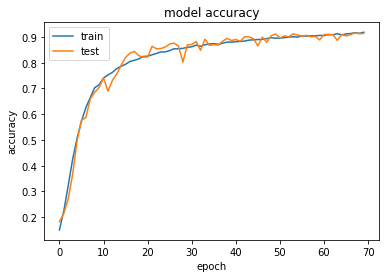

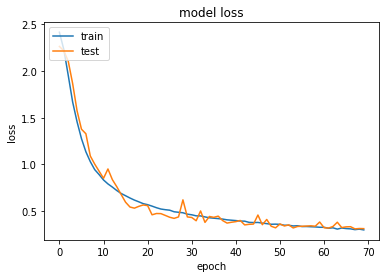

In [15]:
plot_history(history)

# 3. Evaluation

We're gonna do simple evaluation using built-in evaluate function. After that we're gonna calculate confusion matrix using function from tf.math module.

In [16]:
print("Evaluate on test data")
results = classifier.evaluate(val_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
71/71 [==============================] - 3s 32ms/step - loss: 0.3095 - accuracy: 0.9137
test loss, test acc: [0.30950450897216797, 0.9136897921562195]


In [17]:
# Save model to file
classifier.save('svhn_model.h5')

In [17]:
# if we just wanna evaluate existing model, we can start here
classifier = tf.keras.models.load_model('svhn_model.h5')

In [18]:
# get predictions
y_pred = classifier.predict(val_ds, verbose=2)

y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:
   # append true labels
   y_true.append(label_batch)

correct_labels = tf.concat([item for item in y_true], axis = 0)
# calculate confusion matrix
confusion = tf.math.confusion_matrix(
              labels = np.argmax(correct_labels, axis=1),      # get true labels 
              predictions = np.argmax(y_pred, axis=1),  # get predicted labels 
              num_classes=10)

print(confusion)

71/71 - 2s
tf.Tensor(
[[ 19  55  46  40  35  29  31  31  30  18]
 [ 60 157 103  98  81  61  70  50  82  61]
 [ 44 104  96  83  55  43  51  42  54  35]
 [ 37 100  56  60  50  42  49  52  40  39]
 [ 51  67  59  42  46  31  43  33  32  35]
 [ 29  76  46  51  36  47  39  31  36  23]
 [ 27  63  45  39  38  42  35  28  30  30]
 [ 26  50  59  35  31  36  26  30  24  26]
 [ 25  61  37  46  28  26  26  21  34  28]
 [ 34  53  41  32  35  27  25  21  22  23]], shape=(10, 10), dtype=int32)


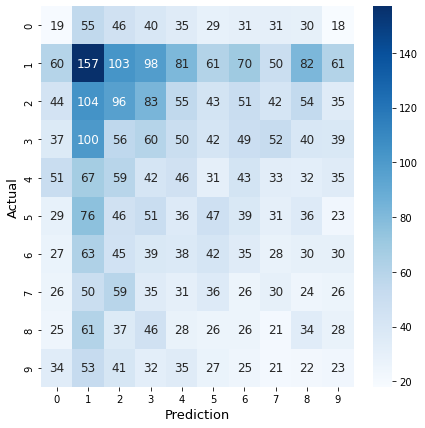

In [19]:
# Visualize confusion matrix
cm = pd.DataFrame(confusion.numpy(), # convert to array
               range(10),range(10))

plt.figure(figsize = (7, 7))
matrix_plot = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', xticklabels=val_ds.class_names,
            yticklabels=val_ds.class_names, cmap='Blues')
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)

fig = matrix_plot.get_figure()
fig.savefig('confusion_matrix.png', format='png', facecolor='white', dpi=150, bbox_inches='tight')
plt.show()